In [3]:
!pip install matplotlib
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 10.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.3/253.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 kB 7.6 MB/s eta 0:00:0000:01
  Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn
import datetime
import re
from os import listdir
import sys
import copy as cp
sys.path.insert(0, '../model_tf2')
import parameters
import plotting_functions as pf
import data_utils as du
import model_utils as mu
import behaviour_analyses as ba

# ADD YOUR DIRECTORIES HERE

path = '/Users/lab25/generalising-structural-knowledge/Summaries/'
save_dirs = [path]

# Choose which training run data to load
date = '2025-01-30'
run = '0'
index_load = None

# Try to find the most recent trained model data to run a forward pass
recent = -1
time_series_smoothing = 0
print("what2")
try:
    # Find model path and iteration index
    print("what3")
    save_dir, index = pf.get_model_path(run, date, save_dirs, recent)
    print("what")
    # Run forward path for retrieved model, if folder doesn't exist yet
    print("what4",date, run, int(index),save_dir)
    print(ba.save_trained_outputs(date, run, int(index), base_path=save_dir, force_overwrite=False, n_envs_save=16))
    print("what6")
    model = ba.save_trained_outputs(date, run, int(index), base_path=save_dir, force_overwrite=False, n_envs_save=16)
    print("what5",model)
except FileNotFoundError:
    print('No trained model weights found for ' + date + ', run ' + run + '.')
    
# Load data, generated either during training or in a forward pass through a trained model
print("are we getting the data?")
data, para, list_of_files, save_path, env_dict = pf.get_data(save_dirs, run, date, recent, index=index, smoothing=time_series_smoothing, n_envs_save=16)
print("yes?",data,para)
# Unpack data
x_all = data.x
g_all = data.g
p_all = data.p
acc_s_t_to = data.acc_to
acc_s_t_from = data.acc_from
positions = data.positions
adj = data.adj
x_timeseries = data.x_timeseries
x_gt_timeseries = data.x_gt_timeseries
p_timeseries = data.p_timeseries
g_timeseries = data.g_timeseries
pos_timeseries = data.pos_timeseries
final_variables = data.final_variables
# Group timeseries together for backward compatibility
timeseries = (g_timeseries, p_timeseries, pos_timeseries)
# Assign parameters
params, widths, n_states = para

# Specify plotting parameters. Some fields will be added after loading data & parameters
plot_specs = mu.DotDict({'smoothing': 0, # spatial ratemap smoothing. Needs to be odd, or 0 for no smoothing
                      'maxmin': True,
                      'cmap': 'jet',
                      'show': True,
                      'circle': True,
                      'g_max_0': False,
                      'p_max_0': True,
                      'save': False,
                      'split_freqs': True,
                      'mult': 4,
                      'cell_num': True,
                      'rectangle': {'marker_size': 20,
                                  'marker_shape': 's'},
                      'hexagonal': {'marker_size': 150,
                                  'marker_shape': 'H'},
                      'family_tree': {'marker_size': 20,
                                  'marker_shape': 'h'},
                      'line_ti': {'marker_size': 20,
                                  'marker_shape': 's'},
                      'wood2000': {'marker_size': 150,
                                  'marker_shape': 's',
                                  'plot_all': False,},
                      'frank2000': {'marker_size': 150,
                                  'marker_shape': 's',
                                  'plot_all': False,},
                      'grieves2016': {'marker_size': 50,
                                  'marker_shape': 'H',
                                  'plot_all': False,},
                      'sun2020': {'marker_size': 50,
                                  'marker_shape': 's'},
                      'nieh2021': {'marker_size': 50,
                                  'marker_shape': 's',
                                  'plot_all': False,
                                  'smooth': True,
                                  'surface': True,},
                     })

import seaborn
seaborn.set_style(style='white')
seaborn.set_style({'axes.spines.bottom': False,'axes.spines.left': False,'axes.spines.right': \
                   False,'axes.spines.top': False})

masks, g_lim, p_lim = pf.sort_data(g_all, p_all, widths, plot_specs)

what2
what3
/Users/lab25/generalising-structural-knowledge/Summaries/2025-01-30/run0
['tem_34632.data-00000-of-00001', 'tem_40626.data-00000-of-00001', 'tem_58608.index', 'tem_26640.index', 'tem_33300.index', 'tem_3330.index', 'tem_41292.index', 'tem_11322.data-00000-of-00001', 'tem_39960.index', 'tem_1998.data-00000-of-00001', 'tem_98568.data-00000-of-00001', 'tem_30636.data-00000-of-00001', 'tem_21978.data-00000-of-00001', 'tem_44622.data-00000-of-00001', 'tem_9990.index', 'tem_27972.index', 'tem_20646.data-00000-of-00001', 'tem_97236.index', 'tem_63270.index', 'tem_47952.index', 'tem_11322.index', 'tem_56610.data-00000-of-00001', 'tem_59940.index', 'tem_45954.data-00000-of-00001', 'tem_10656.index', 'tem_69930.index', 'tem_38628.index', 'tem_68598.data-00000-of-00001', 'tem_43290.data-00000-of-00001', 'tem_24642.data-00000-of-00001', 'tem_29970.data-00000-of-00001', 'tem_9990.data-00000-of-00001', 'tem_93906.index', 'tem_49284.index', 'tem_52614.data-00000-of-00001', 'tem_77922.inde

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lab25/generalising-structural-knowledge/Summaries/2025-01-30/run0/save/adj_99900.npy.gz'

In [13]:
masks = [(np.sum(g,1) + np.sum(p,1) != 0).tolist() for g,p in zip(g_all, p_all)]
trainalbe_variables = model.trainable_weights

In [14]:
for env in range(params.n_envs_save):
    num_correct = np.sum(acc_s_t_to[env] * positions[env])
    proportion = num_correct / sum(positions[env])
    approx_num = proportion * n_states[env]
    print(env, '  Num_states : ', n_states[env], '   Approx proportion : ', np.round(proportion, decimals=3), \
          '   Approx num : ', np.round(approx_num, decimals=0))

0   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
1   Num_states :  52    Approx proportion :  [0.987]    Approx num :  [51.]
2   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
3   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
4   Num_states :  52    Approx proportion :  [0.99]    Approx num :  [51.]
5   Num_states :  52    Approx proportion :  [0.988]    Approx num :  [51.]
6   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
7   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
8   Num_states :  52    Approx proportion :  [0.988]    Approx num :  [51.]
9   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
10   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
11   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
12   Num_states :  52    Approx proportion :  [0.989]    Approx num :  [51.]
13   Num_s

In [24]:
env0 = 1
env1 = 2
envs = [env0, env1]

## GRAPHS

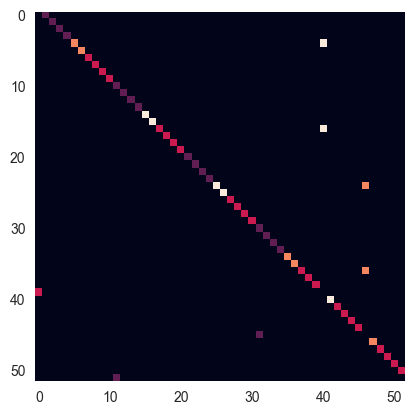

In [31]:
env_ = env_dict.curric_env.envs[0]
env_.world()
# plot different transitions in different colours
for i in range(env_.adj.shape[0]):
    for j in range(env_.adj.shape[1]):
        if env_.adj[i,j] != 0:
            ri, rt = env_.relation(i,j)
            env_.adj[i,j] = ri + 1
plt.imshow(env_.adj)
w,v = np.linalg.eig(env_.adj)

In [5]:
!pip install networkx



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


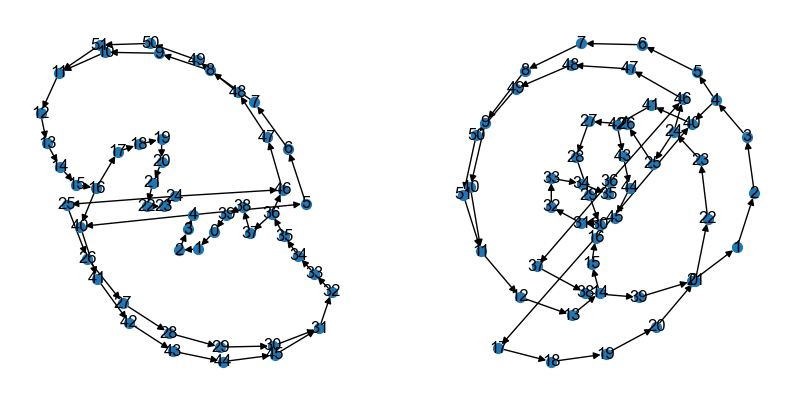

In [26]:

import networkx as nx
try:
    plt.figure(figsize=(10,5))
    for i, env in enumerate([env0, env1]):
        adj_ = pf.remove_zero_adj(adj[env])
        
        plt.subplot(1,2,i + 1)
        g = nx.from_numpy_array(adj_,create_using=nx.DiGraph)
        pos_nodes = nx.spring_layout(g, iterations=500)
        nx.draw(g, pos=pos_nodes, node_size=50, with_labels=True)
    
    plt.show()
except TypeError:
    plt.close('all')
    pass

## AGENT COVERAGE

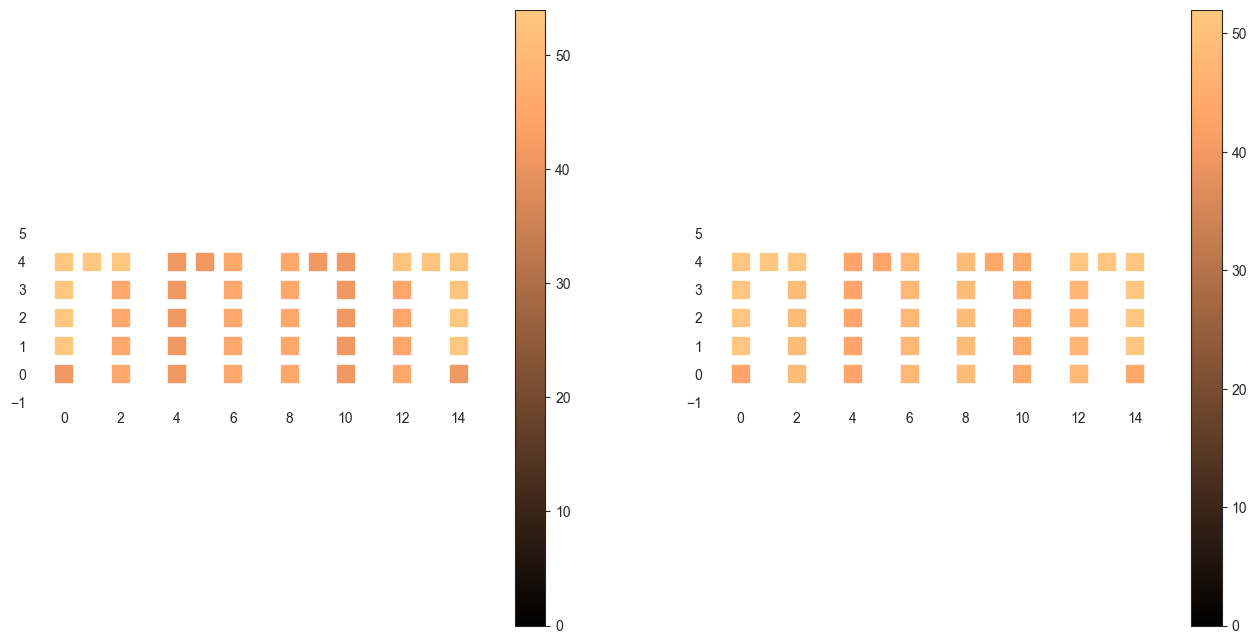

[0.00641975] [0.00395062]


In [27]:
plot_specs.cmap = 'copper'

try:
    s = plot_specs[parameters.old2new(params.world_type)].marker_size
    marker = plot_specs[parameters.old2new(params.world_type)].marker_shape
except:
    print('exceptiom')
    s, marker = 10, 'H'
#xs, ys = get_node_positions(env, params, plot_specs=plot_specs)
figsize = (16,8)

plt.figure(figsize=figsize) 
for i, env in enumerate([env0, env1]):
    plt.subplot(1,2,i+1)
    pos, bins = np.histogram(pos_timeseries[env], bins=np.arange(n_states[env]+1))
    xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(cells=pos, _plot_specs=plot_specs)
    plt.scatter(xs, ys, c=cell_prepared, s=s, marker=marker, vmin=0, cmap=plot_specs.cmap)
    plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
    plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()

plt.show()

print(min(positions[env0]), min(positions[env1]))

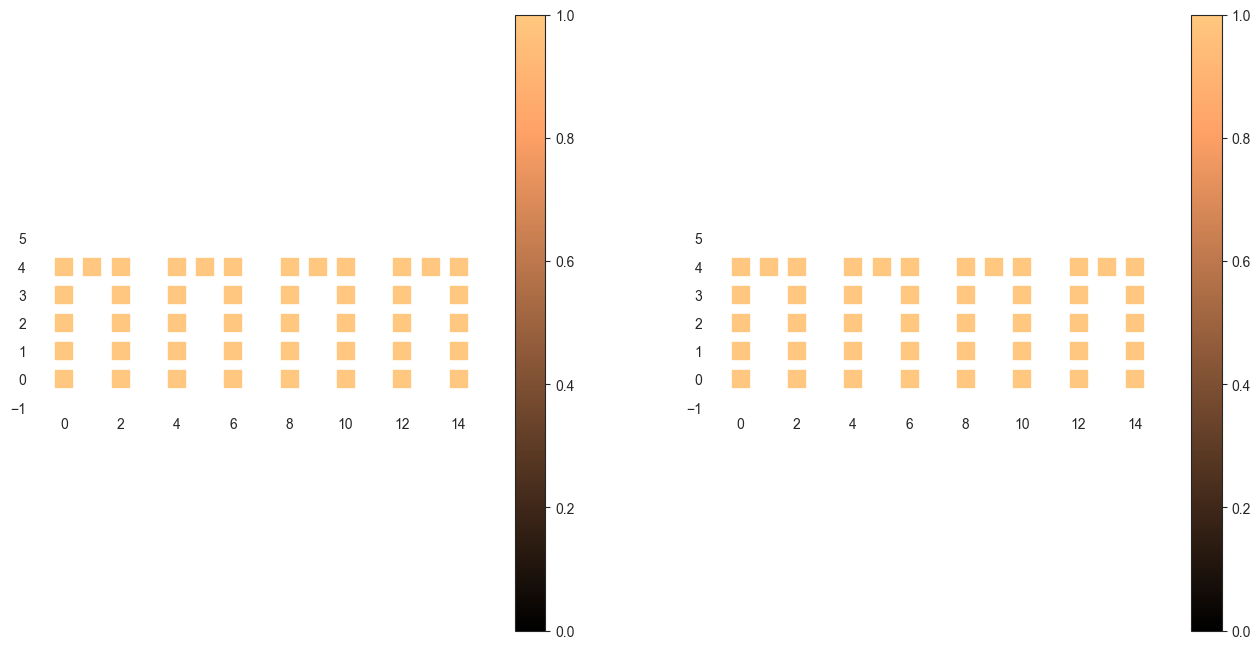

In [28]:
# where the agent didnt go much shown in black
figsize= (8 * len(envs), 8)

plt.figure(figsize=figsize)

for i, env in enumerate([env0, env1]):
    pos, bins = np.histogram(pos_timeseries[env], bins=np.arange(n_states[env]+1))
    a = pos > 5
    plt.subplot(1,2,i+1)
    xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(cells=a.astype(float), _plot_specs=plot_specs)
    plt.scatter(xs, ys, c=cell_prepared, s=s, marker=marker, vmin=0, cmap=plot_specs.cmap)
    plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
    plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()    
    
plt.show()

## ACCURACY MAPS

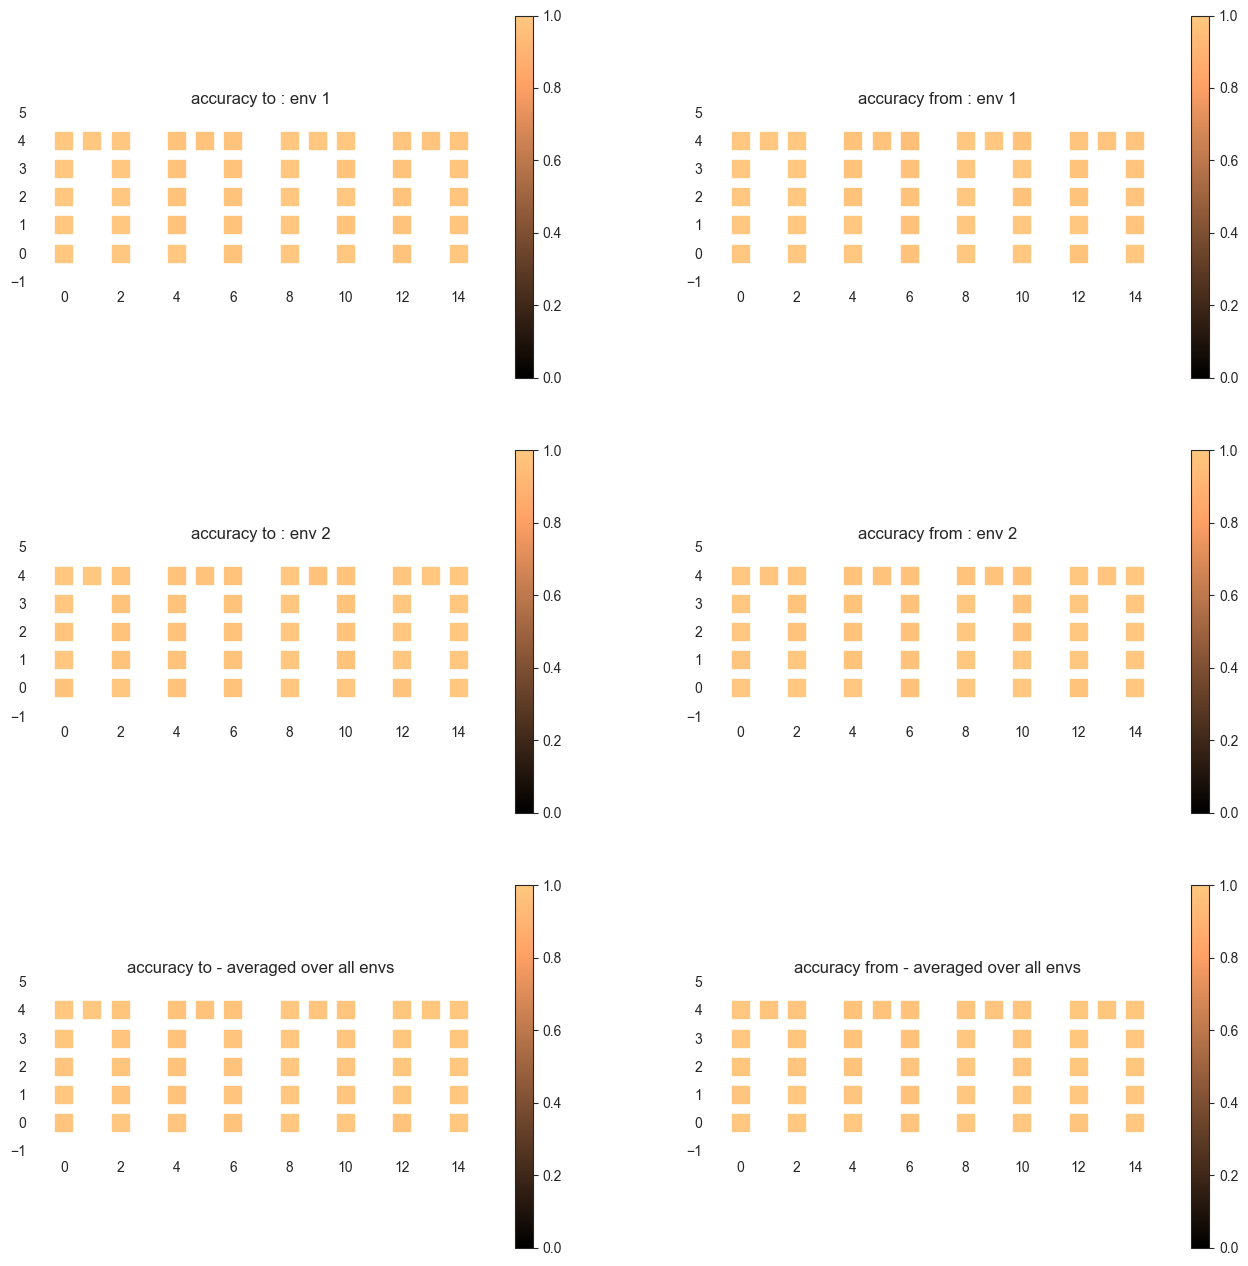

In [29]:
figsize= (8 * len(envs), 16)

plt.figure(figsize=figsize)        
for i, env in enumerate([env0, env1]):
    plt.subplot(3,2,2*i+1)    
    xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(cells=acc_s_t_to[env], _plot_specs=plot_specs)
    plt.scatter(xs, ys, c=cell_prepared, cmap=plot_specs.cmap, s=s, marker=marker, vmin=0, vmax=1)
    plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
    plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()
    plt.title('accuracy to : env ' + str(env))
    
    plt.subplot(3,2,2*i+2)
    xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(cells=acc_s_t_from[env], _plot_specs=plot_specs)
    plt.scatter(xs, ys, c=cell_prepared, cmap=plot_specs.cmap, s=s, marker=marker, vmin=0, vmax=1)
    plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
    plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()
    plt.title('accuracy from : env ' + str(env))
    
    

# average across envs - should do this properly with position counts
env = 0
# find other envs of same size
accs_to = [acc_to for i, acc_to in enumerate(acc_s_t_to) if n_states[i] == n_states[env]]
accs_from = [acc_from for i, acc_from in enumerate(acc_s_t_from) if n_states[i] == n_states[env]]

plt.subplot(3,2,5)
xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(cells=np.mean(accs_to, axis=0), _plot_specs=plot_specs)
plt.scatter(xs, ys, c=cell_prepared, cmap=plot_specs.cmap, s=s, marker=marker, vmin=0, vmax=1)
plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.title('accuracy to - averaged over all envs')
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(3,2,6)
xs, ys, cell_prepared = env_dict.curric_env.envs[env].get_node_positions(cells=np.mean(accs_from, axis=0), _plot_specs=plot_specs)
plt.scatter(xs, ys, c=cell_prepared, cmap=plot_specs.cmap, s=s, marker=marker, vmin=0, vmax=1)
plt.xlim(xmin=min(xs)-1, xmax=max(xs)+1)
plt.ylim(ymin=min(ys)-1, ymax=max(ys)+1)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.title('accuracy from - averaged over all envs')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## ENTORHINAL CELLS

In [21]:
plot_specs.split_freqs = True
plot_specs.n_cells_freq = params.n_grids_all
plot_specs.cmap = 'jet'
plot_specs.node_plot = True
plot_specs.max_min = False

In [42]:
import matplotlib
matplotlib.use('TkAgg')

Cell shape: (52, 120)
Node positions (xs, ys): [0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 5, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 14, 14, 14, 14, 14, 13, 12, 12, 12, 12, 12] [0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0]
Grid: 0 xs: [0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 5, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 14, 14, 14, 14, 14, 13, 12, 12, 12, 12, 12] ys: [0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0] cell_prepared: [ 0.00450163  0.11493904  0.1390114   0.10557261  0.19087718  0.29358232
  0.11110318  0.35215729  0.4046354   0.05553161 -0.27944899 -0.26108572
  0.04754551  0.35414103  0.30407149  0.08782994  0.28171924  0.16915441
  0.09073018  0.14551     0.12413507  0.00450163 -0.27944899  0.05767994
  0.39112622  0.33366403  0.11013556  0.18515997  0.16683795  0.09

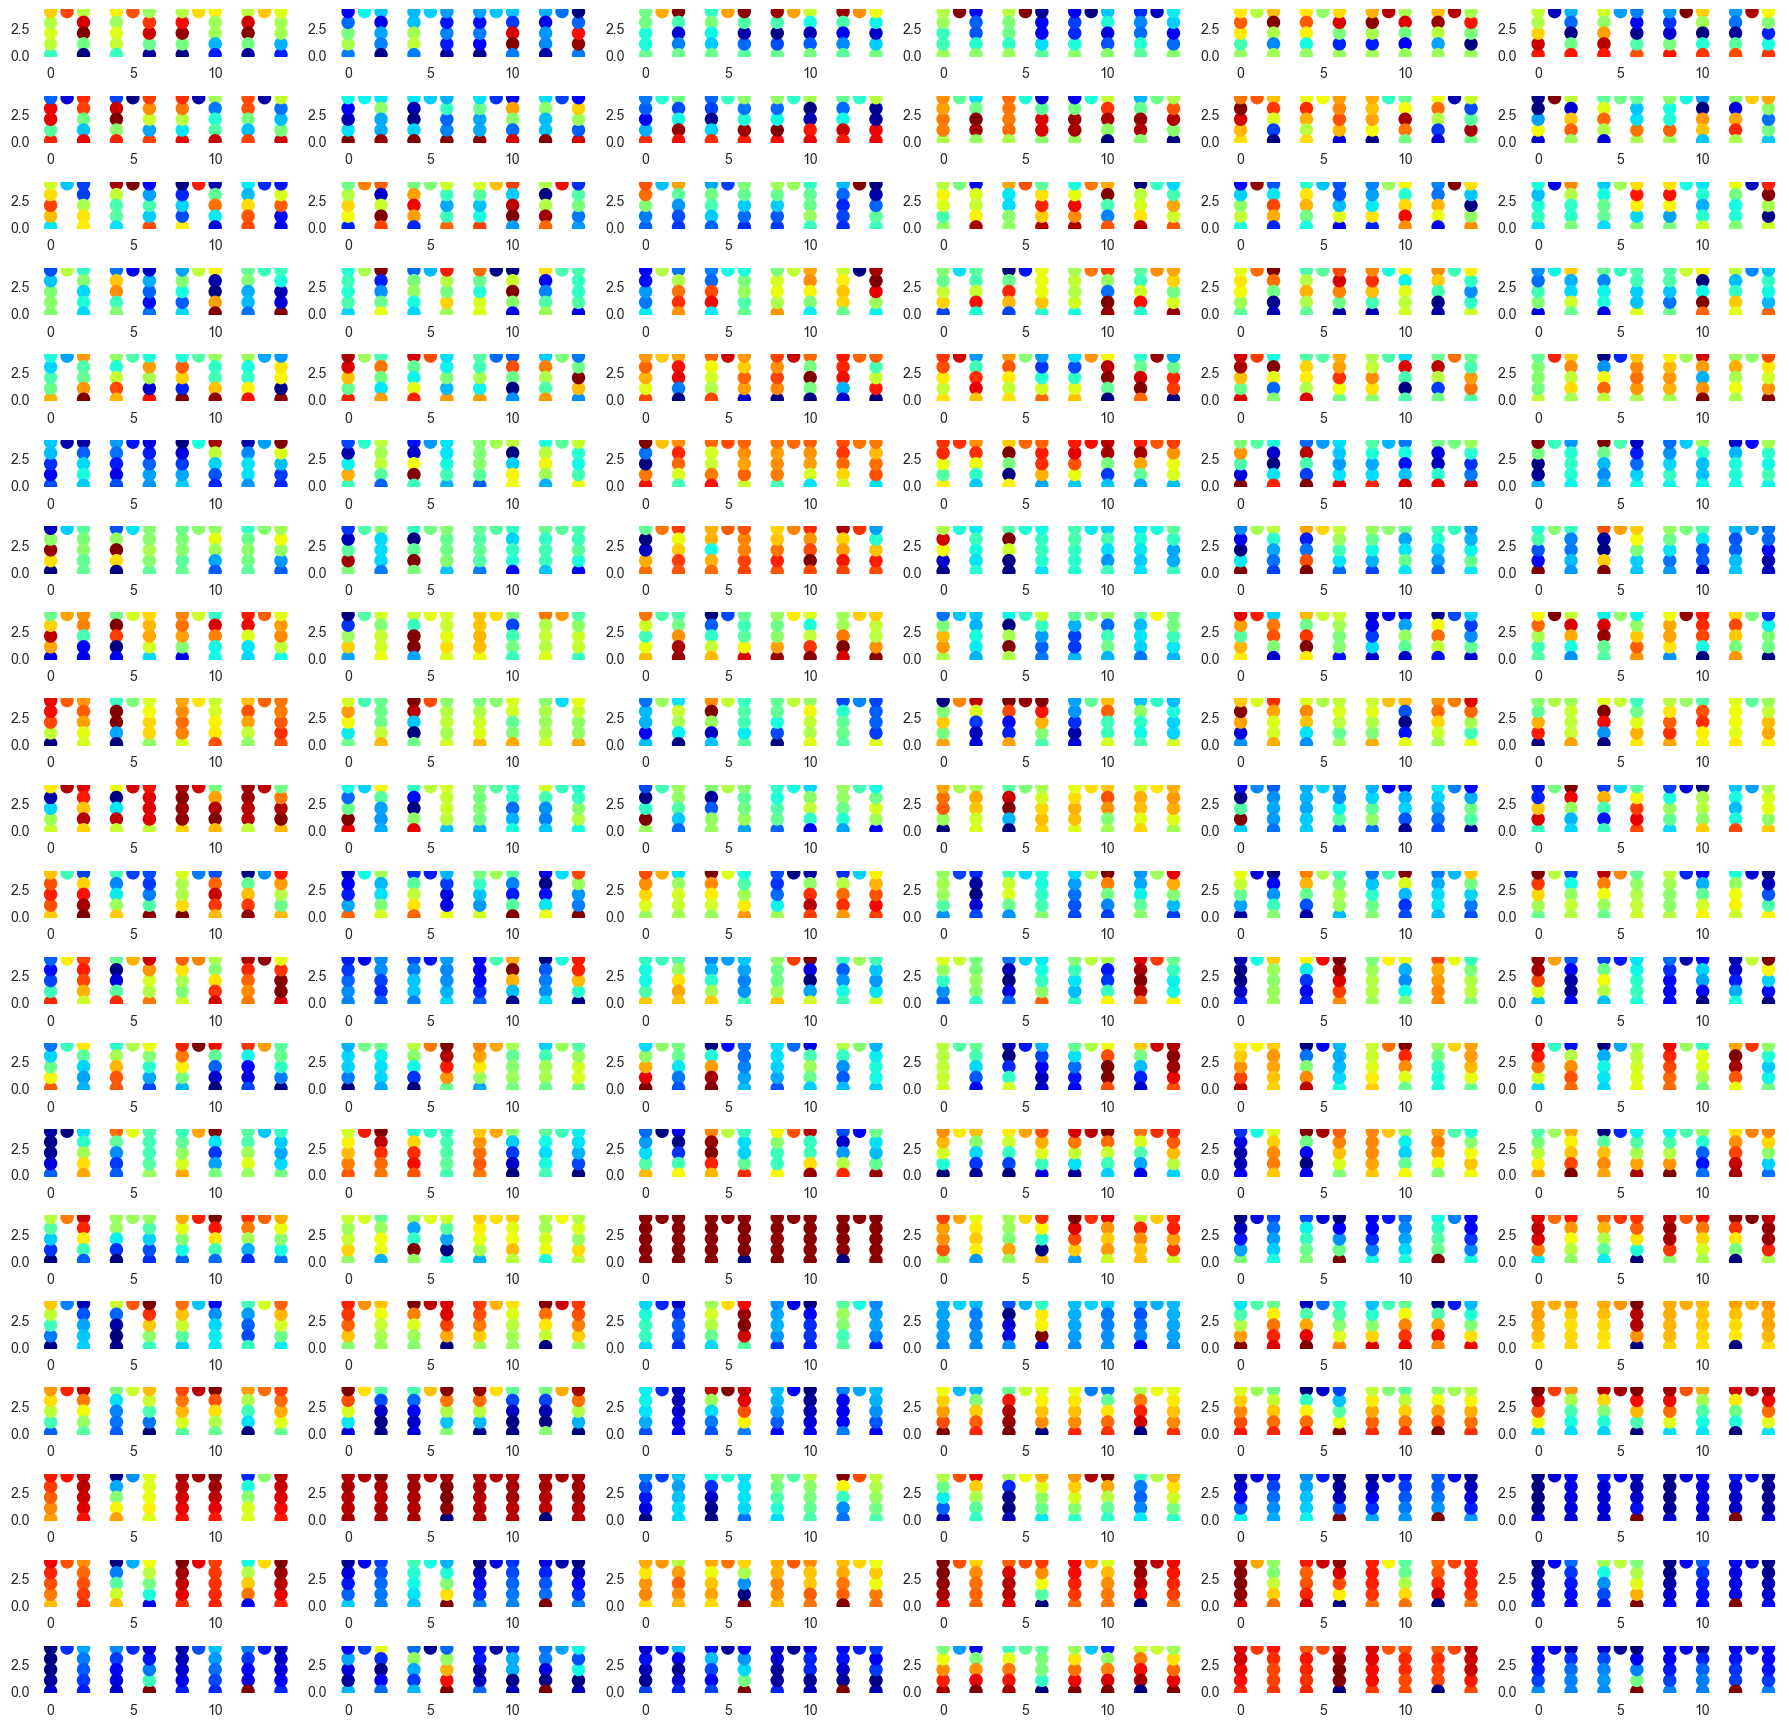

In [22]:
pf.square_plot(g_all, env0, params, plot_specs, name='g0', lims=g_lim, mask=masks[env0], env_class=env_dict.curric_env.envs[env0])

Cell shape: (52, 120)
Node positions (xs, ys): [0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 5, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 14, 14, 14, 14, 14, 13, 12, 12, 12, 12, 12] [0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0]
Grid: 0 xs: [0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 5, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 14, 14, 14, 14, 14, 13, 12, 12, 12, 12, 12] ys: [0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 1, 0] cell_prepared: [-0.00107648  0.10398585  0.12750749  0.09508833  0.18649247  0.29211202
  0.10604601  0.35893747  0.41909844  0.06030839 -0.28716287 -0.26570797
  0.04795126  0.35669965  0.30506635  0.08633891  0.2808103   0.16849449
  0.08925546  0.13989364  0.11334387 -0.00107648 -0.28716287  0.05957826
  0.40112612  0.34081775  0.11202849  0.18675728  0.16795507  0.08

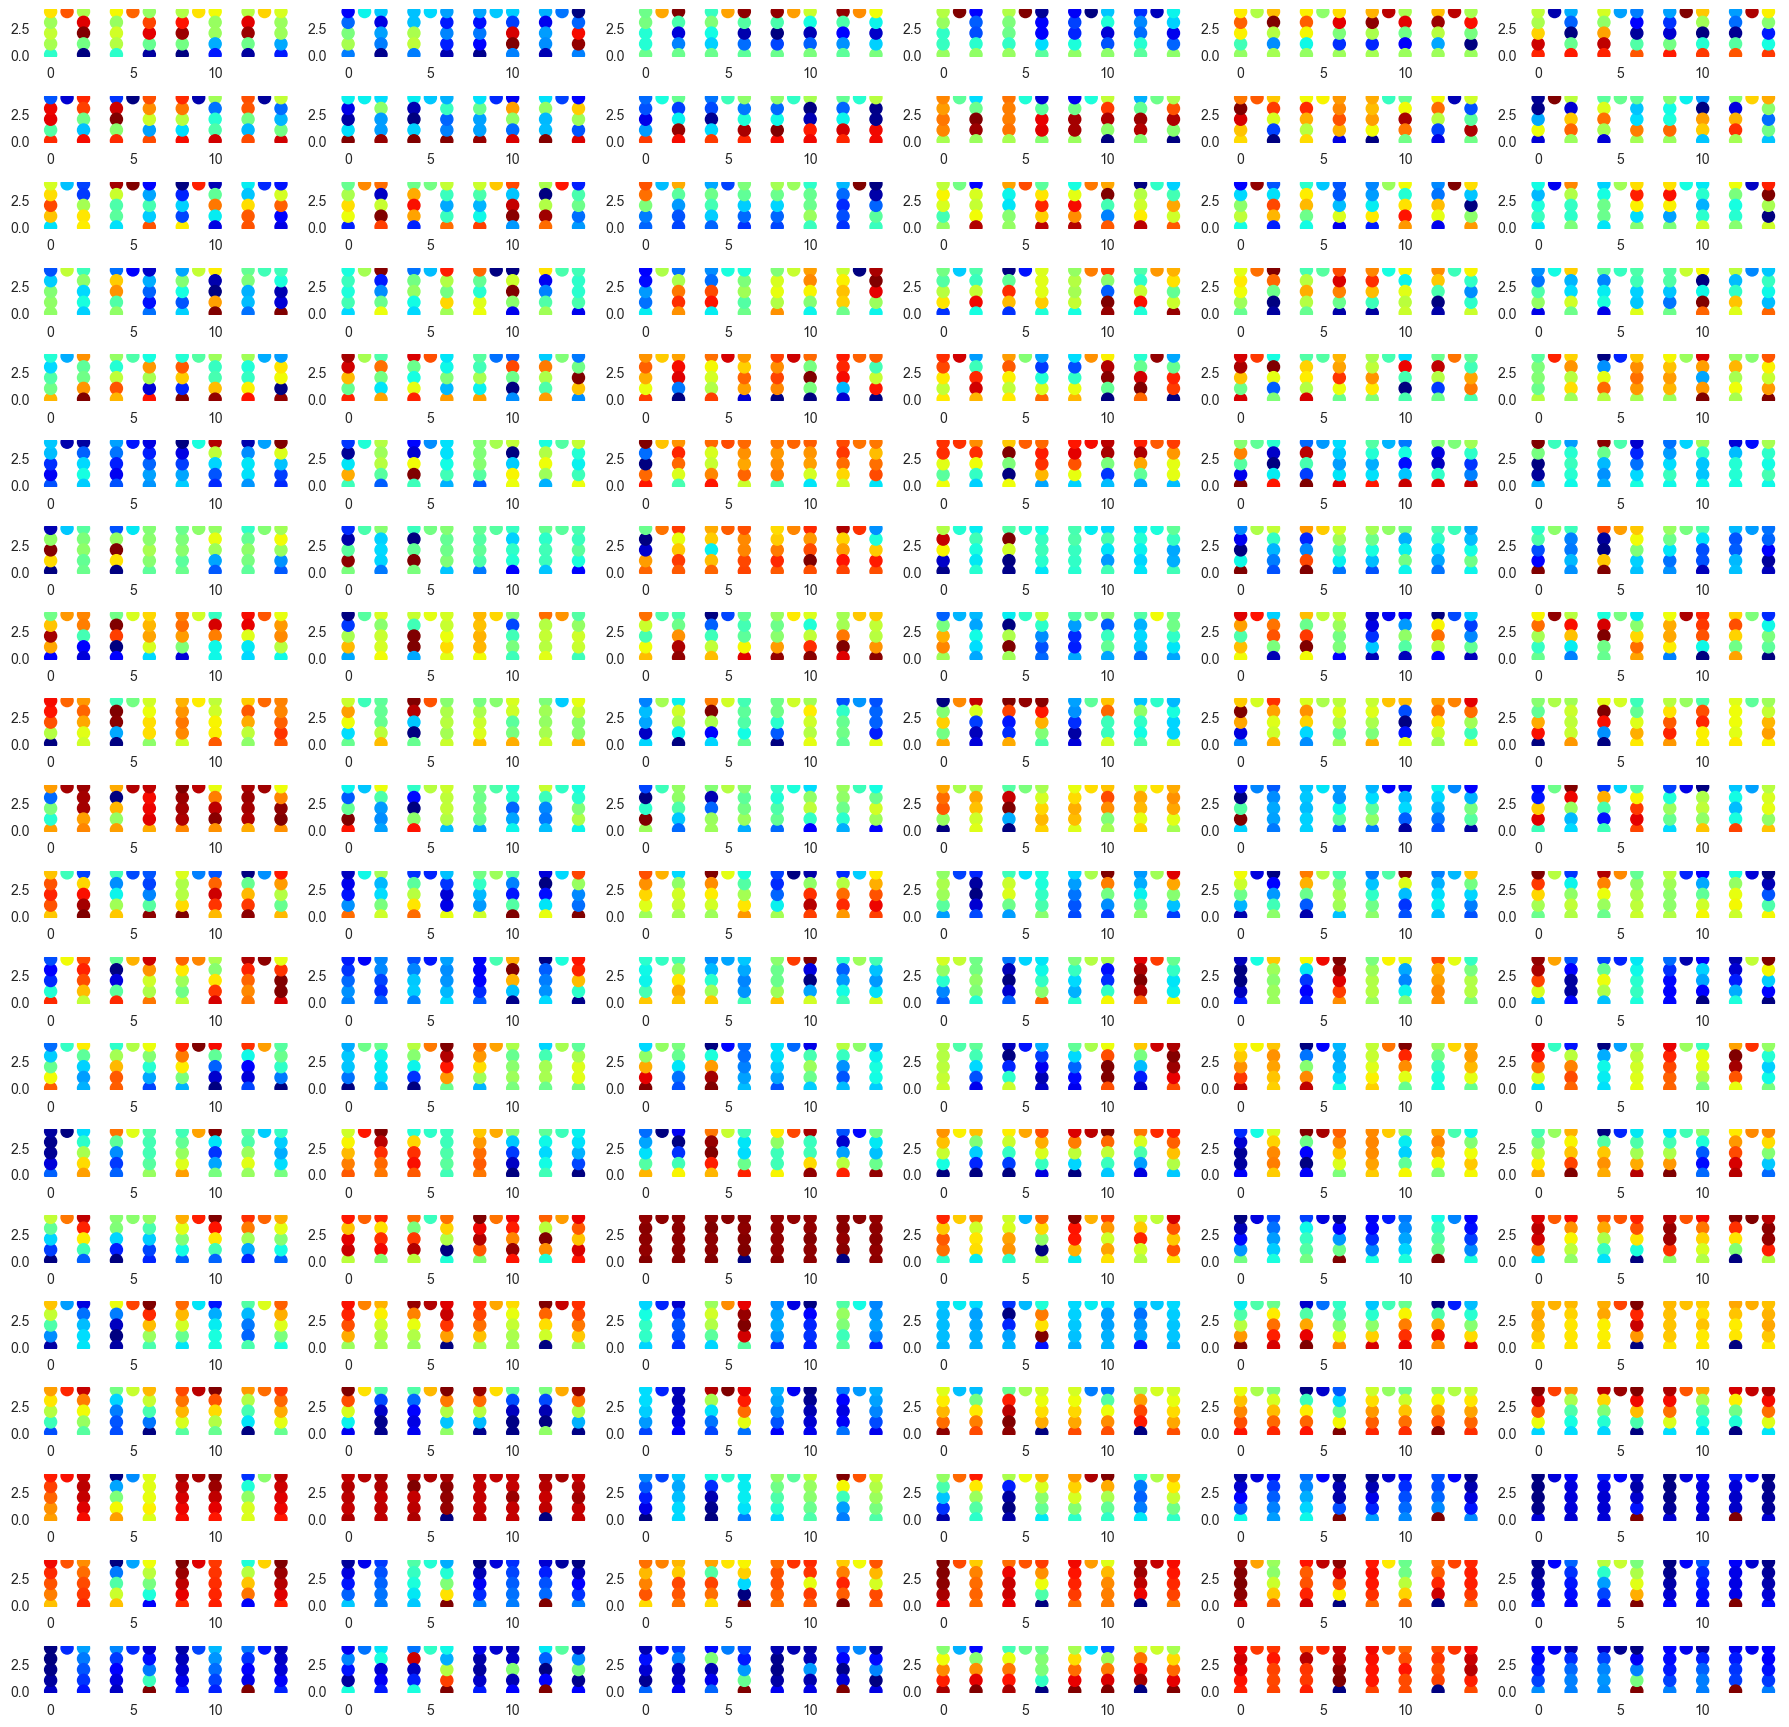

In [23]:
pf.square_plot(g_all, env1, params, plot_specs, name='g1', lims=g_lim, mask=masks[env1], env_class=env_dict.curric_env.envs[env1])